# Import and setup

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import few

from few.trajectory.inspiral import EMRIInspiral
from few.trajectory.ode import SchwarzEccFlux, KerrEccEqFlux
# from few.amplitude.romannet import RomanAmplitude
from few.amplitude.ampinterp2d import AmpInterpKerrEccEq
from few.summation.interpolatedmodesum import InterpolatedModeSum, CubicSplineInterpolant


from few.utils.ylm import GetYlms
from few.utils.modeselector import ModeSelector
from few.summation.interpolatedmodesum import CubicSplineInterpolant
from few import get_file_manager

from few.waveform import (
    FastKerrEccentricEquatorialFlux,
    FastSchwarzschildEccentricFlux, 
    SlowSchwarzschildEccentricFlux, 
    Pn5AAKWaveform,
    GenerateEMRIWaveform
)

from few.utils.geodesic import get_fundamental_frequencies

import GWfuncs
import gc
import pickle
import os
import cupy as cp
import multiprocessing as mp
from multiprocessing import Queue, Process
from functools import partial
from SNR_tutorial_utils import LISA_Noise
from lisatools.sensitivity import *

from few.utils.constants import YRSID_SI, Gpc, MRSUN_SI



# import pandas as pd
# tune few configuration
cfg_set = few.get_config_setter(reset=True)
cfg_set.set_log_level("info");

In [3]:
# Parameters
m1 = 1e6 #M
m2 = 1e1 #mu
a = 0.5
p0 = 9.5
e0 = 0.2
theta = np.pi / 3.0 
phi = np.pi / 4.0  
dt = 10.0
T = 1
xI0 = 1.0 
#in the paper xI0 = 0.866, but that would be non-equatorial case

use_gpu = True 
traj = EMRIInspiral(func=KerrEccEqFlux, force_backend="cuda12x", use_gpu=use_gpu) #theres npoints flag here
amp = AmpInterpKerrEccEq(force_backend="cuda12x") # default lmax=10, nmax=55
interpolate_mode_sum = InterpolatedModeSum(force_backend="cuda12x")
ylm_gen = GetYlms(include_minus_m=False, force_backend="cuda12x")

# Generate amplitudes, trajectory, etc.

In [4]:
N_traj = 100 # change amount of points here 
delta_T = T*YRSID_SI/N_traj 

In [5]:
# Calc trajectory
(t, p, e, x, Phi_phi, Phi_theta, Phi_r) = traj(m1, m2, a, p0, e0, xI0, T=T, dt=delta_T, upsample=True) 

t_gpu = cp.asarray(t)

# Get amplitudes along trajectory
teuk_modes = amp(a, p, e, x)

# Get Ylms
ylms = ylm_gen(amp.unique_l, amp.unique_m, theta, phi).copy()[amp.inverse_lm]

In [6]:
dist = 1.0 # Gpc
factor = dist * Gpc / (m2 * MRSUN_SI)
N_traj = teuk_modes.shape[0]  # number of trajectory points

In [7]:
teuk_modes

array([[ 1.55001444e-19-1.17375858e-19j, -5.10407779e-19+2.23870615e-19j,
        -4.01495449e-19-1.41155523e-19j, ...,
        -3.19075120e-16-2.84958141e-16j,  3.73706358e-17-1.00998204e-16j,
        -6.49495176e-16+6.16414410e-16j],
       [ 1.51497631e-19-1.14461339e-19j, -5.15763323e-19+2.28333974e-19j,
        -3.88852458e-19-1.33634140e-19j, ...,
        -3.22537416e-16-2.98805622e-16j,  3.89582161e-17-1.04391406e-16j,
        -6.31882952e-16+6.08886805e-16j],
       [ 1.47742118e-19-1.11461630e-19j, -5.20340150e-19+2.32378309e-19j,
        -3.75918089e-19-1.26034410e-19j, ...,
        -3.25230478e-16-3.12054982e-16j,  4.04427087e-17-1.07524428e-16j,
        -6.13290793e-16+6.00475188e-16j],
       ...,
       [ 4.66306483e-20+5.10105138e-21j,  6.77651189e-20-8.10453629e-21j,
        -1.99366418e-20+3.54435798e-24j, ...,
         2.41690712e-17-7.18994001e-17j,  4.68097449e-18-3.15361572e-17j,
         3.44935813e-17+2.89162302e-17j],
       [ 4.02715938e-20+4.99852903e-21j,  6.

In [9]:
np.sum(np.isnan(teuk_modes))

array(0)

In [10]:
np.sum(np.isnan(ylms))

array(0)

In [12]:
np.diff(t)

array([315581.49763546, 315581.49763546, 315581.49763546, 315581.49763546,
       315581.49763546, 315581.49763546, 315581.49763546, 315581.49763546,
       315581.49763546, 315581.49763546, 315581.49763546, 315581.49763546,
       315581.49763546, 315581.49763546, 315581.49763546, 315581.49763546,
       315581.49763546, 315581.49763546, 315581.49763546, 315581.49763546,
       315581.49763546, 315581.49763546, 315581.49763546, 315581.49763546,
       315581.49763546, 315581.49763546, 315581.49763546, 315581.49763546,
       315581.49763546, 315581.49763546, 315581.49763546, 315581.49763546,
       315581.49763546, 315581.49763546, 315581.49763546, 315581.49763546,
       315581.49763546, 315581.49763546, 315581.49763546, 315581.49763546,
       315581.49763546, 315581.49763546, 315581.49763546, 315581.49763546,
       315581.49763546, 315581.49763546, 315581.49763546, 315581.49763546,
       315581.49763546, 315581.49763546, 315581.49763546, 315581.49763546,
       315581.49763546, 3

# Interpolate -> sum (one full waveform)

Still have problems with NaNs

In [68]:
%%time

t_gpu = cp.asarray(t)

# need to prepare arrays for sum with all modes due to +/- m setup
ls = amp.l_arr[: teuk_modes.shape[1]]
ms = amp.m_arr[: teuk_modes.shape[1]]
ns = amp.n_arr[: teuk_modes.shape[1]]

keep_modes = np.arange(teuk_modes.shape[1])
temp2 = keep_modes * (keep_modes < amp.num_m0) + (keep_modes + amp.num_m_1_up) * (
    keep_modes >= amp.num_m0
) 

ylmkeep = np.concatenate([keep_modes, temp2])
ylms_in = ylms[ylmkeep]
teuk_modes_in = teuk_modes

cp.cuda.Stream.null.synchronize()

CPU times: user 1.66 ms, sys: 410 μs, total: 2.07 ms
Wall time: 1.6 ms


In [69]:
%%time

# perform summation
waveform1 = interpolate_mode_sum(
    t_gpu,
    teuk_modes_in,
    ylms_in,
    traj.integrator_spline_t, #TODO: check if splines were generated from the non-upsampled ones 
    traj.integrator_spline_phase_coeff[:, [0, 2]],
    ls,
    ms,
    ns,
    dt=dt,
    T=T,
)

cp.cuda.Stream.null.synchronize()

CPU times: user 13 s, sys: 37 ms, total: 13.1 s
Wall time: 13 s


In [70]:
waveform1[~np.isnan(waveform1)]

array([ 0.21930317+0.1927499j ,  0.21993501+0.19211859j,
        0.22056368+0.19148616j, ..., -0.22390125+0.03192086j,
        0.2360731 +0.0654566j , -0.24079725-0.04782278j], shape=(347140,))

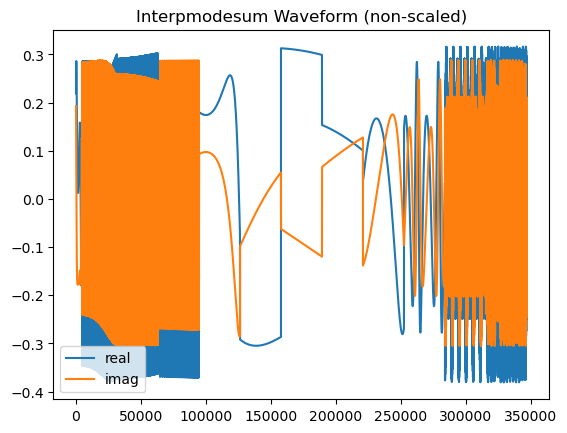

In [71]:
plt.plot(waveform1.get().real, label='real')
plt.plot(waveform1.get().imag, label='imag')
plt.title('Interpmodesum Waveform (non-scaled)')
plt.legend(loc='lower left')
plt.show()

# Interpolate 1 mode with interpmodesum

In [72]:
# Get mode labels
mode_labels = [f"({l},{m},{n})" for l,m,n in zip(amp.l_arr, amp.m_arr, amp.n_arr)]

In [73]:
mode_idx = 1

In [82]:
%%time

# interpolate only one mode 
waveform1_1 = interpolate_mode_sum(
    t_gpu,
    teuk_modes_in[:, mode_idx:mode_idx+1],
    ylms_in[mode_idx:mode_idx+1],
    traj.integrator_spline_t,
    traj.integrator_spline_phase_coeff[:, [0, 2]],
    ls[mode_idx:mode_idx+1],
    ms[mode_idx:mode_idx+1],
    ns[mode_idx:mode_idx+1],
    dt=dt,
    T=T,
)

cp.cuda.Stream.null.synchronize()

CPU times: user 7.5 ms, sys: 3 ms, total: 10.5 ms
Wall time: 9.22 ms


In [83]:
waveform1_1[~np.isnan(waveform1_1)]

array([-1.47868018e-19+6.48565825e-20j, -9.56066143e-20-1.30118114e-19j,
        1.59742640e-19-2.35299476e-20j, ...,
       -5.50036954e-20+1.58181526e-19j,  1.62979208e-19+3.85300853e-20j,
        2.16605094e-20-1.66065049e-19j], shape=(347140,))

In [84]:
np.sum(~np.isnan(waveform1_1))/len(waveform1_1) * 100

array(11.22450002)

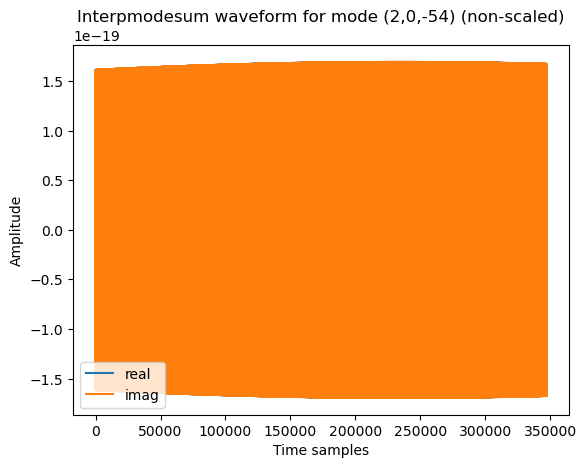

In [85]:
plt.plot(waveform1_1.get().real, label='real')
plt.plot(waveform1_1.get().imag, label='imag')
plt.title(f'Interpmodesum waveform for mode {mode_labels[mode_idx]} (non-scaled)')
plt.xlabel('Time samples')
plt.ylabel('Amplitude')
plt.legend(loc='lower left')
plt.show()

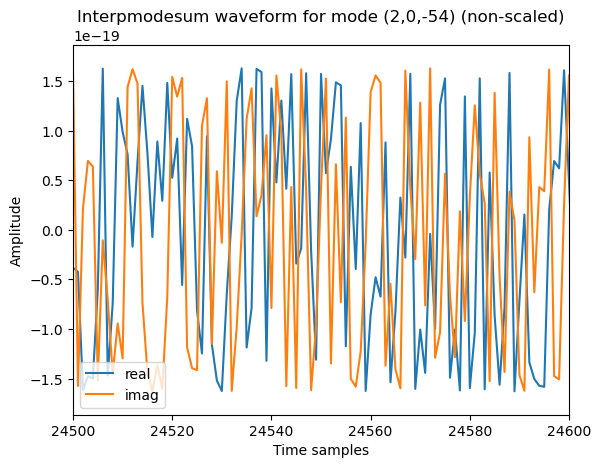

In [86]:
plt.plot(waveform1_1.get().real, label='real')
plt.plot(waveform1_1.get().imag, label='imag')
plt.title(f'Interpmodesum waveform for mode {mode_labels[mode_idx]} (non-scaled)')
plt.xlabel('Time samples')
plt.ylabel('Amplitude')
plt.legend(loc='lower left')
plt.xlim(2.45e4,2.46e4)
plt.show()

# Interpolate 1 mode with CubicSpineInterpolant

In [124]:
teuk_modes[:,mode_idx].shape

(99,)

In [127]:
%%time

# # selecting one mode
# mode_real = teuk_modes[:, mode_idx].real 
# mode_imag = teuk_modes[:, mode_idx].imag
# mode_all = np.vstack([mode_real, mode_imag])

init_len = len(t)
teuk_modes_single = teuk_modes[:, mode_idx]
num_teuk_modes = 1 #teuk_modes.shape[1]

length = init_len
ninterps = 2 * num_teuk_modes  # 2 for re and im
y_all = cp.zeros((ninterps, length))

y_all[:num_teuk_modes] = teuk_modes_single.T.real
y_all[num_teuk_modes : 2 * num_teuk_modes] = teuk_modes_single.T.imag

# interpolation
spline = CubicSplineInterpolant(t, mode_all, force_backend="cuda12x")

# dense sampling
t_new = np.linspace(t[0], t[-1], int(T*YRSID_SI/dt))

# evaluating the spline at new dense time array
interp_mode = spline(t_new)
interp_mode_comp = interp_mode[0] + 1j * interp_mode[1]

CPU times: user 116 ms, sys: 1.03 ms, total: 117 ms
Wall time: 114 ms


Keep in mide not as simple as A*ylms.. Better to use interpmodesum for one mode just in case